<a href="https://colab.research.google.com/github/christianlehre/Unibo-Applied-Machine-Learning/blob/master/AppliedML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import useful modules**

In [ ]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Dataset**


The dataset we consider in this project is collected from the UCI machnine learning repository which can be accessed [here](https://archive.ics.uci.edu/ml/index.php). 
The dataset consists of 177 samples with 3 different categories based on 13 explanatory variables resulting from a chemical analysis of wine grown in the same region in italy. The different categories arise from different cultivates the wine is derived from.
All features, or explanatory varaibles are continous, so there is no need to hot-encode (or similarily) the features before feeding the data into the algorithms. 

You can read more about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Wine).

The goal of this project is to use classical machine learning tecniques to classify the category of wines based on the features in the dataset. We will use a handful of classification algorithms and compare their results. 



**Loading the data**

In [ ]:
filepath = './Wine.csv'

colnames = [
    'Label',
    'Alcohol',
    'Malic acid',
    'Ash',
    'Alcalinity of ash',
    'Magnesium',
    'Total phenols',
    'Flavanoids',
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity',
    'Hue',
    'OD280/OD315 of diluted wines',
    'Proline'
]

data = pd.read_csv(filepath,header = 0, names = colnames)


**Data exploration**


Text(0.5, 1.0, 'Distribution of the different classes')

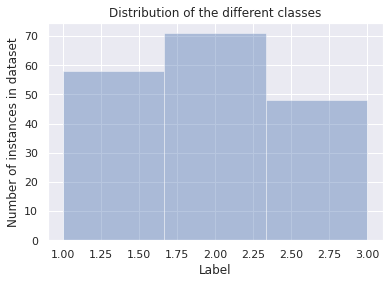

In [ ]:
sns.distplot(data['Label'],hist = True,kde = False)
plt.ylabel('Number of instances in dataset')
plt.title('Distribution of the different classes')

In [ ]:
data.head()


,Label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [ ]:
data.describe()

,Label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,1.943503,12.993672,2.339887,2.366158,19.516949,99.587571,2.292260,2.023446,0.362316,1.586949,5.054802,0.956983,2.604294,745.096045
std,0.773991,0.808808,1.119314,0.275080,3.336071,14.174018,0.626465,0.998658,0.124653,0.571545,2.324446,0.229135,0.705103,314.884046
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.360000,1.600000,2.210000,17.200000,88.000000,1.740000,1.200000,0.270000,1.250000,3.210000,0.780000,1.930000,500.000000
50%,2.000000,13.050000,1.870000,2.360000,19.500000,98.000000,2.350000,2.130000,0.340000,1.550000,4.680000,0.960000,2.780000,672.000000
75%,3.000000,13.670000,3.100000,2.560000,21.500000,107.000000,2.800000,2.860000,0.440000,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


We observe from the summary statistics outputted by the 
```
data.describe()
```
function above that features spans a great range of values. For example we see that the magnesium content have values that are several orders of magnitude greater than the values for the Nonflavanoid phenols. 

This suggest that we should normalize the features of our dataset to a common scale, such that the magnitude of the values of the features does not influence the results, i.e the predictions. If this is not done, features that ranges over greater values will, in many models, influence the result of the predictions more than features that ranges over smaller values - independent on the actual importance of the feature.

We do this using the 

```
StandardScaler()
```
function in the sklearn library, transforming the data to have zero mean and unit variance. 



**Scatterplot of data and correlation of features**




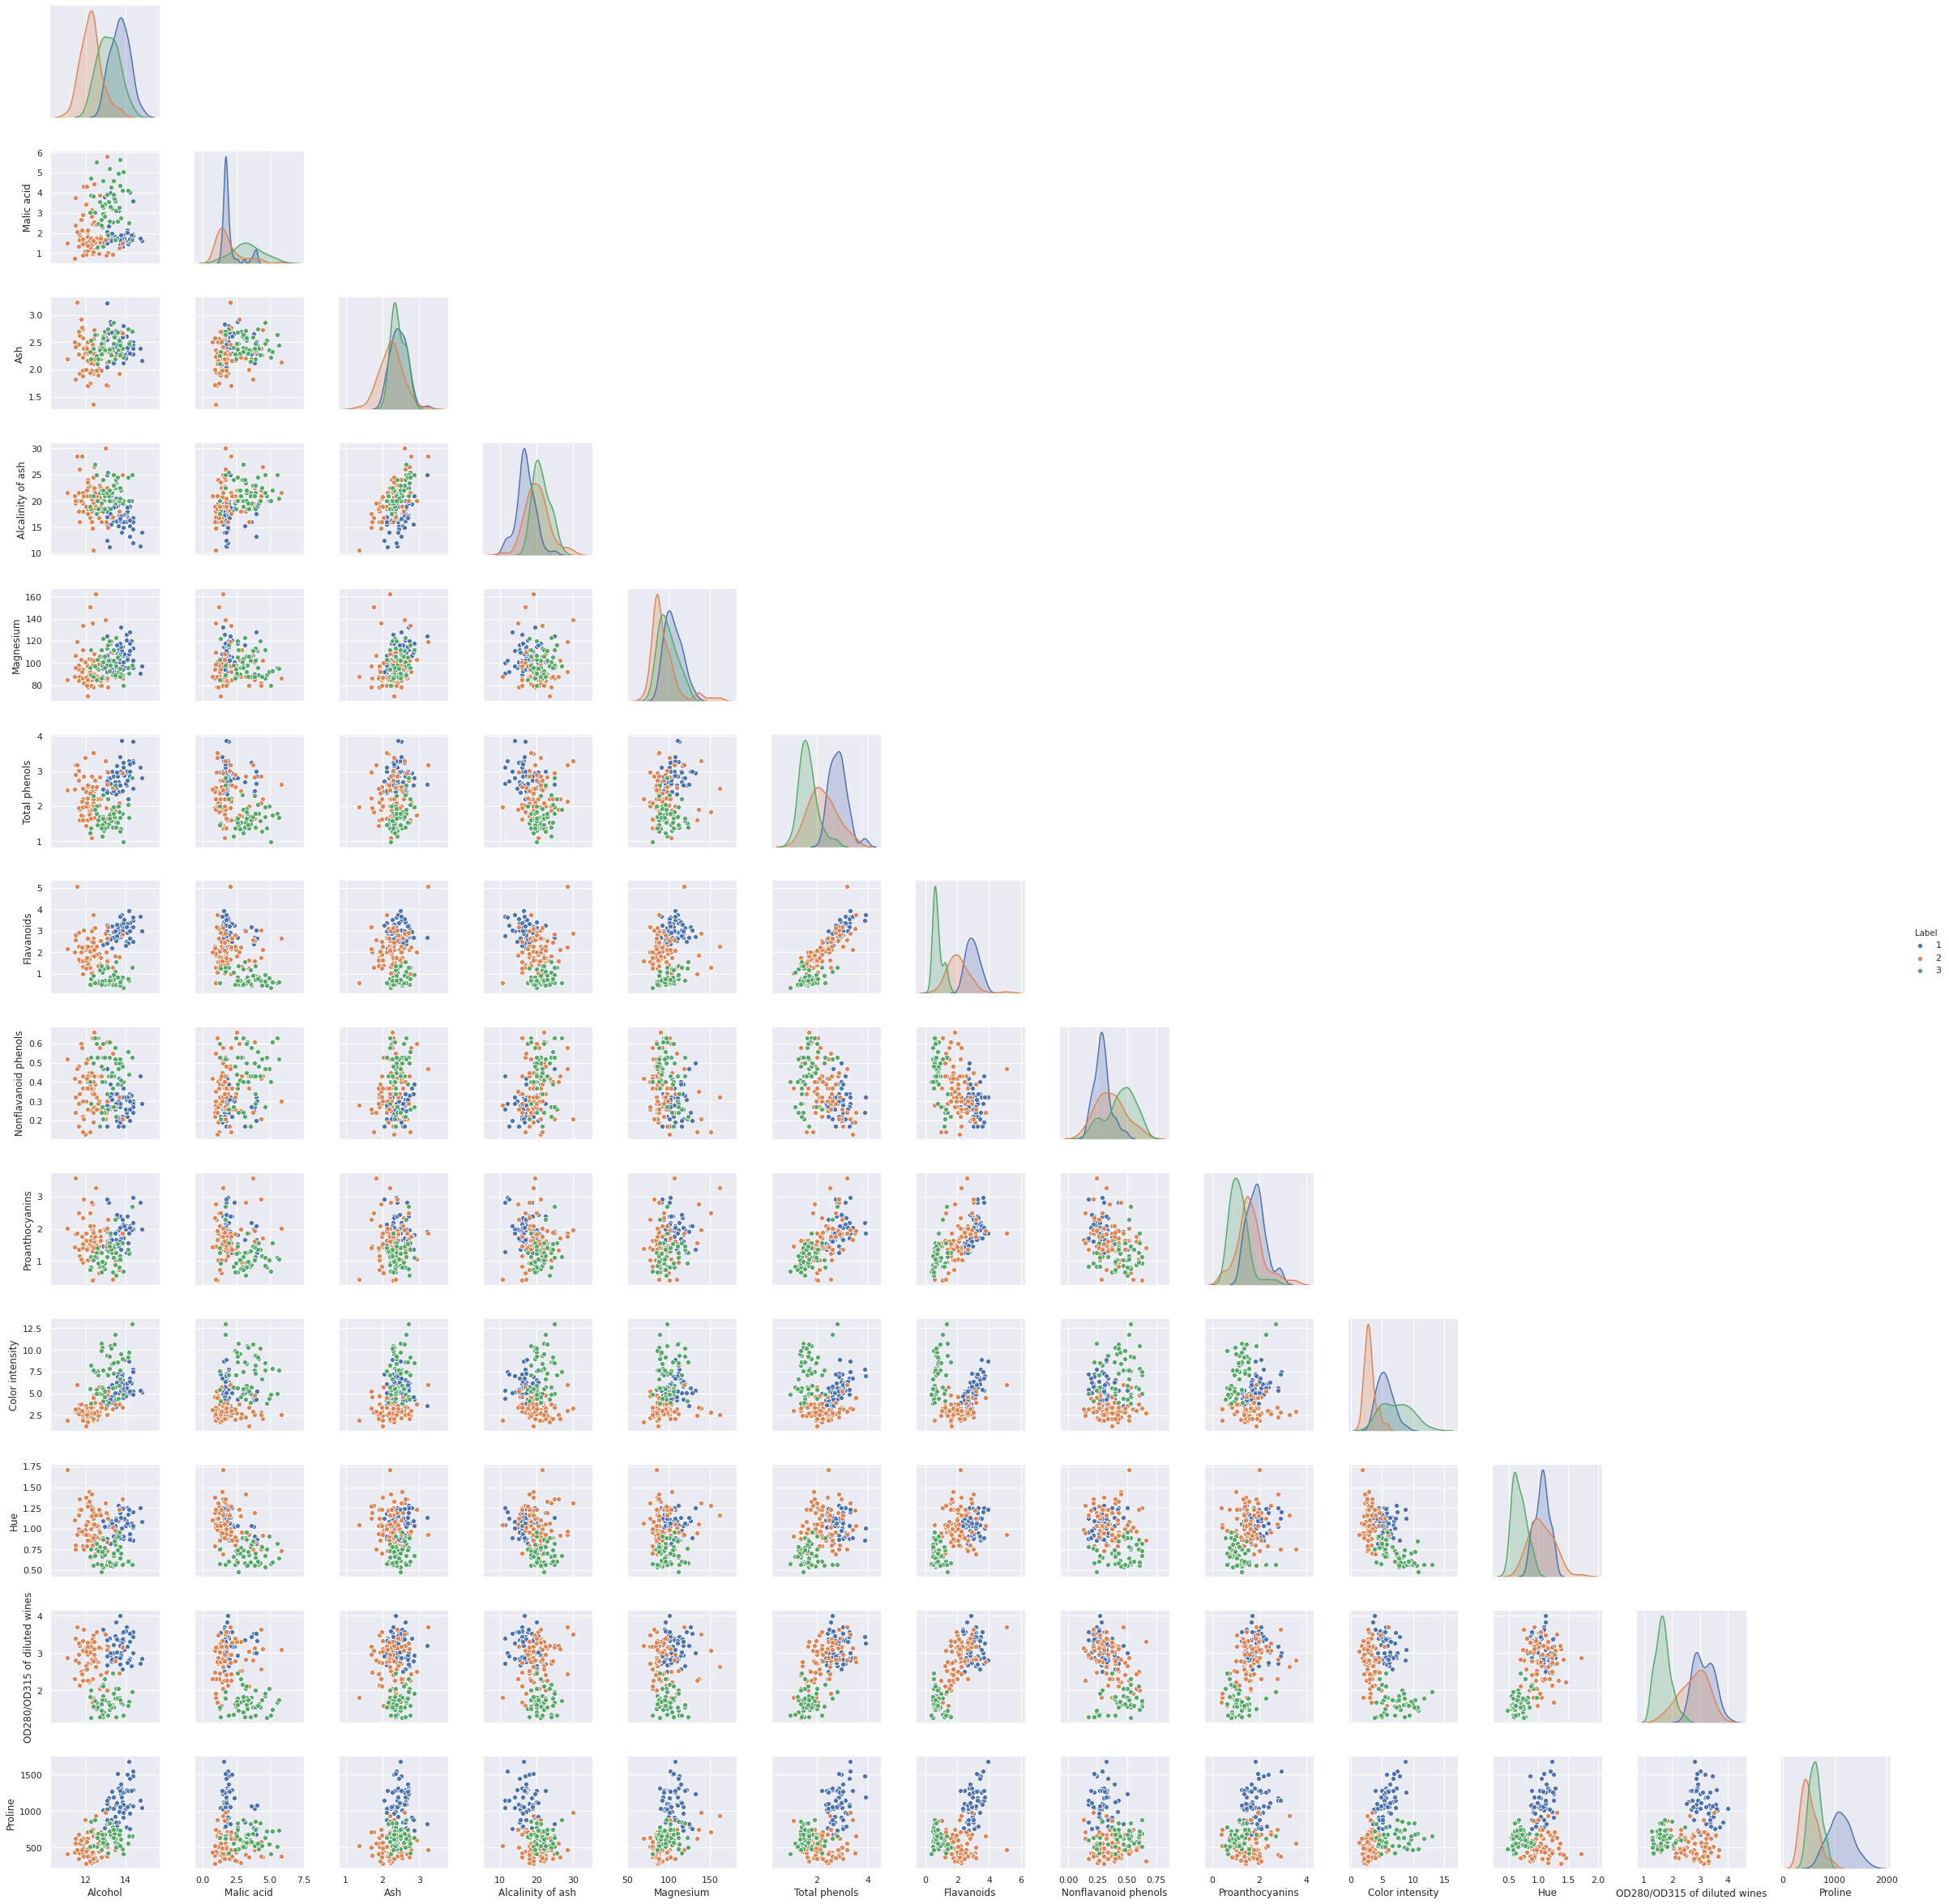

In [ ]:
sns.pairplot(data,hue = 'Label',corner = True)


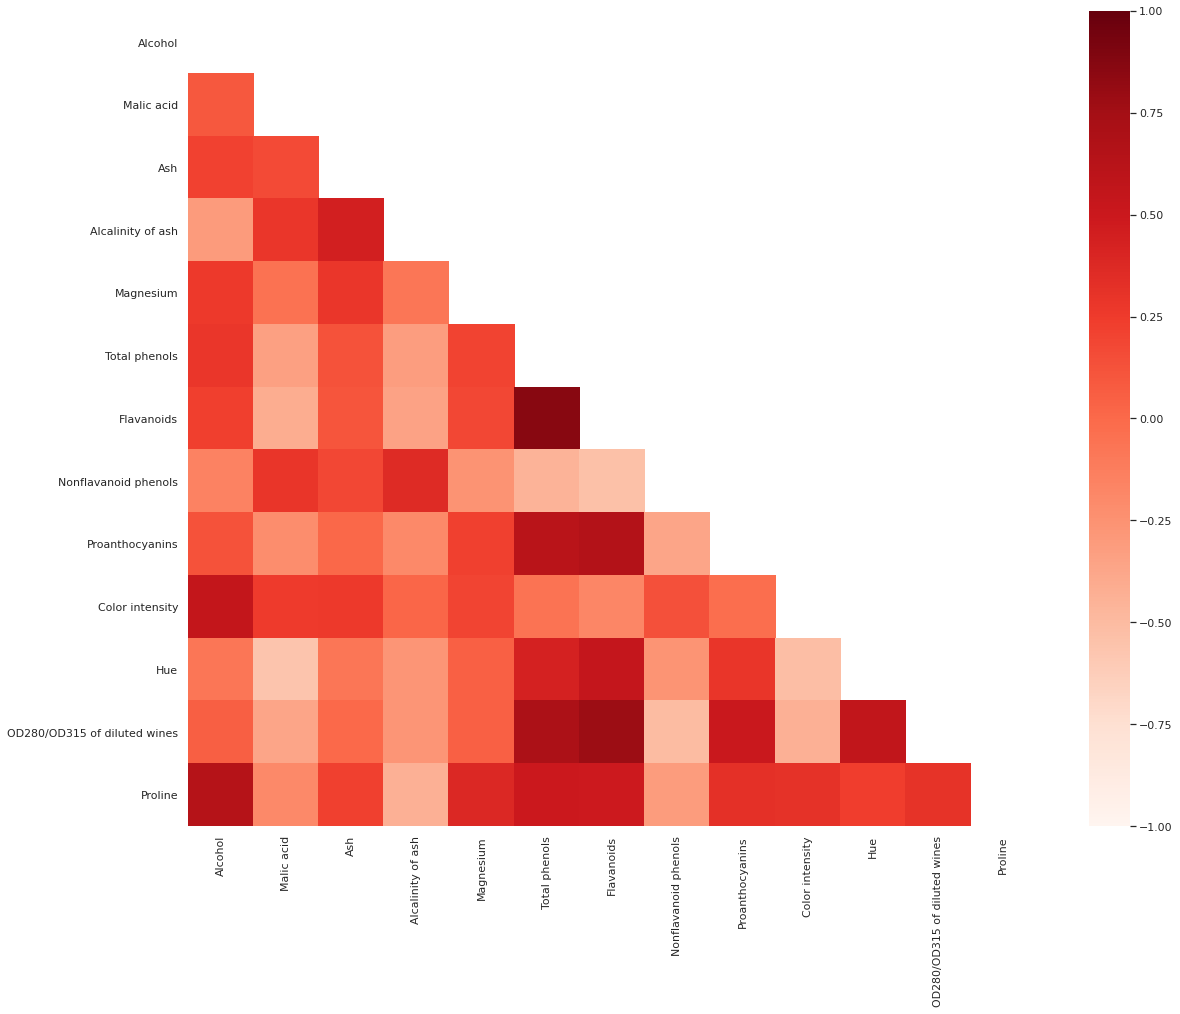

In [ ]:
df_full = data.iloc[:,1:] # exclude label
fig = plt.figure(figsize = (19,15))
corr = df_full.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
  sns.heatmap(corr,mask = mask,vmin = -1, vmax = 1, cmap = 'Reds')

From the correlation matrix above we see that some of the variables in the dataset are highly correlated, e.g Flavanoids and Total Phenols. However, we will not move forward with excluding variables until we have seen the variable importance plot further down the pipeline. 

**Data preparation and parameter tuning**

In our models there are certain hyperparameters we will need to set before training. We will find these by cross validation.

We will first split our data into a training set and a test set, where the test set contains 30% of the samples. 
Further on, when training the models, we perform a 5-fold crossvalidation to tune hyperparameters. When we have found the optimal hyperparameters for our models we refit them using the complete training set, and test the performance using the misclassification rate. 

The misclassification rate is simply the fraction of wrongly classified samples. 
$$
MCE = \frac{1}{n}\sum_{i = 1}^{n}1( \hat y \ne y),
$$
where $\hat y$ and $y$ are the predicted and true classes, respectively.


To perform parameter tuning for the classifiers we will need a validation set. This is obtained by doing a K-fold cross-validation, where K is the number of folds or batches in the training data. During an iteration, one fold is considered the validation set while the remaining (K-1) folds are used for training. The process is repeated K times, where the validation and training folds are interchanged.

Each iteration in the K-fold crossvalidation will yields its own misclassification error, and we will thus obtain K different misclassification errors for each value of the parameter in the search. 
To obtain a single value for each parameter we will simply use the mean value of all MCEs, i.e

$$
MCE_{CV} = \frac{1}{K}\sum_{k = 1}^{K}MCE_k, 
$$
where $MCE_{CV}$ is the misclassification error for a single parameter, and $MCE_k$ is the miscalssification error for that same parameter on the $k$th fold.
The optimal parameter, and thus the parameter we will use when refitting the model on the complete training set, is the parameter which minimize this misclassification error. 

Splitting the data into a training set, test set and a single validation set is usually not preferred, as the datasets are prone to sampling variability in terms of the splitting, and drastically reduce the number of training samples. This approach will thus not generalize well to unseen data. Another option is the Leave-one-out crossvalidation, where each sample in the dataset is a single fold. This is not usually preferred as it is computationally expensive (need to fit the model n times, n being the sample size) and it may cause excessive variability of the accuracy (since each validation set only contains a single sample).

A simple schematic of a K-fold crossvalidation procedure with K = 5 folds is shown below. The image is downloaded from the scikitlearn  [documentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)


![schematic of a K-fold crossvalidation with K = 5 folds](https://drive.google.com/uc?id=189kRvSMOEdygZgFtsxW3SA2NnuZ6HnKW)





 



Training set - X: (123,13), y: (123)
Test set -  X: (54,13), y: (54)


Text(0.5, 1.0, 'Distribution of classes in training and test set')

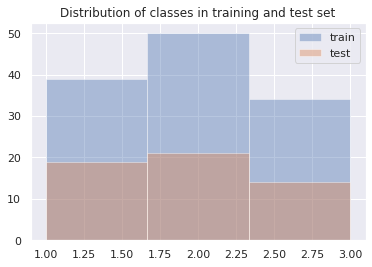

In [ ]:
y = np.array(data.iloc[:,0])
X = np.array(df_full) 

# normalize the data to a common scale
standard_scaler = preprocessing.StandardScaler()
X = standard_scaler.fit_transform(X)

# split data into training and test set
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.30, random_state = 42,shuffle = True)
print('Training set - X: ({},{}), y: ({})'.format(X_train.shape[0],X_train.shape[1],len(y_train)))
print('Test set -  X: ({},{}), y: ({})'.format(X_test.shape[0],X_test.shape[1],len(y_test)))

# 5-fold crossvalidation splits
cv = KFold(n_splits = 5, random_state = 42, shuffle = True)

sns.distplot(y_train,kde = False,label = 'train')
sns.distplot(y_test,kde = False,label = 'test')
plt.legend()
plt.title('Distribution of classes in training and test set')

From the above printout and plot we observe how the training and test set are distributed. The training set consists of 123 samples, while the test set consists of 54 samples. We will now throw away the test set and focus on the training set for training and evaluating the model. Note that the training set as a whole is not used directly for model evaluation, but is split up into seperate training and validation sets as described above. 

**Variable importance plot and feature selection**

Our dataset is rather sparse in terms of number of samples, and has quite a number of features. In other words, we have a high-dimensional dataset with few samples. Thus, we believe that our models will easily overfit on this dataset without sufficient regularization. This follows from the intuition that more samples allows for more complex models. In the case of overfitting, our model(s) will fit the training set too good, and will not generalize well to unseen data. 

Using the random forest classifier introduce another tool which is useful when doing exploratory analysis, namely the variable importance plot. The variable importance plot provides us with a visual representation of the most significant variables in terms of the  mean decrease in the gini index, which is a statistical propery related to the pureness of nodes of the decision trees making up the random forest. Each explanatory variable is used to split the trees in the forest, possibly multiple times, and each time one use a variable to split, we record the corresponding decrese in the gini index, and average all decreases for each variable. By doing this one obtains a summary statistic for each predictor in the dataset, yielding the relative importance of the variables. 
In general, the greater the relative importance of a variable, the better predictive power 

By looking at the variable importance plot below, and setting a threshold of $0.05$, a lot of the variables in the original dataset is removed, and we are left with 6 explanatory variables for the dependent variabale, which in this case is the label of the wine. This means that using our chosen threshold level of $0.05$, there are only 6 out of the original 13 explanatory variables that are significant at this threshold level. We will continue our analysis using this new dataset containing 6 explanatory variables.


Text(0.5, 1.0, 'Variable Importance plot')

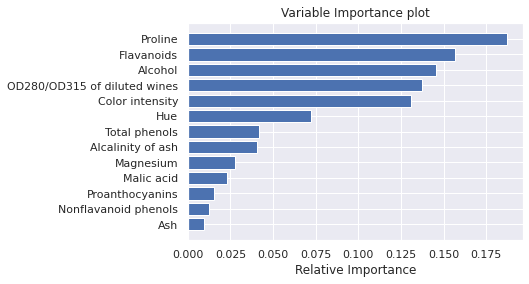

In [ ]:
rfc = RandomForestClassifier(random_state=1)

rfc.fit(X_train,y_train)

# Make variable importance plot
importance = rfc.feature_importances_
sorted_importances = np.argsort(importance)
colnames_X = df_full.columns

sorted_cols = [colnames_X[s] for s in sorted_importances]
padding = np.arange(len(colnames_X)) + 0.5

plt.barh(padding, importance[sorted_importances], align='center')
plt.yticks(padding, sorted_cols)
plt.xlabel("Relative Importance")
plt.title("Variable Importance plot")


In [ ]:
keep_vars = colnames_X[importance > 0.05]

data_new = data[keep_vars]

X_new = np.array(data_new)

y_new = y

X_new = standard_scaler.fit_transform(X_new)

X_train_new,X_test_new, y_train_new,y_test_new = train_test_split(X_new,y_new,test_size = 0.30)
print('Training set - X: ({},{}), y: ({})'.format(X_train_new.shape[0],X_train_new.shape[1],len(y_train_new)))
print('Test set -  X: ({},{}), y: ({})'.format(X_test_new.shape[0],X_test_new.shape[1],len(y_test_new)))



Training set - X: (123,6), y: (123)
Test set -  X: (54,6), y: (54)


The remaining features, based on the variable importance discussed above, are summarized in the output below. Based on our chosen threshold, we consider these variables to be the most significant variables in terms of preictive power.

In [ ]:
data_new.describe()

,Alcohol,Flavanoids,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,12.993672,2.023446,5.054802,0.956983,2.604294,745.096045
std,0.808808,0.998658,2.324446,0.229135,0.705103,314.884046
min,11.030000,0.340000,1.280000,0.480000,1.270000,278.000000
25%,12.360000,1.200000,3.210000,0.780000,1.930000,500.000000
50%,13.050000,2.130000,4.680000,0.960000,2.780000,672.000000
75%,13.670000,2.860000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.080000,13.000000,1.710000,4.000000,1680.000000


By plotting the correlation matrix of the explanatory variables we still see that there exist som correlation between variables of the new dataset. However, we will continue using this dataset for our analysis. 

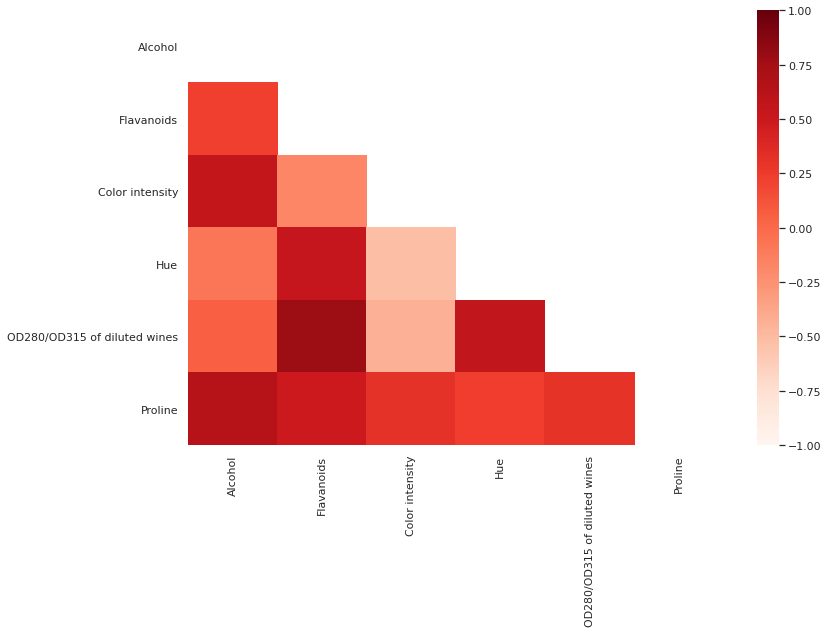

In [ ]:
df = data_new
fig = plt.figure(figsize = (12,8))
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
  sns.heatmap(corr,mask = mask,vmin = -1, vmax = 1, cmap = 'Reds')

**Confusion matrices**

When calcualting the misclassification rate we also show the confusion matrices for a more visual result of the predictive power of the models we consider. A confusion matrix is simply a visualization of the classified samples in the test set, where correctly classified samples are on the main diagonal while misclassified samples are on the off-diagonal elements. 
Each element $(i,j)$ of the matrix corresponds to predicted class $i$ and actual class $j$, such that indiced $(i,i)$ corresponds to correctly classified samples, which are on the main diagonal.

A generic confuction matrix for a 3-class problem is shown below 

$
\begin{array}{|l|l|l|}
\hline
\text{Correctly classified class 1}      & \text{Predicted class 1, actual class 2} & \text{Predicted class 1, actual class 3} \\ \hline
\text{Predicted class 2, actual class 1} & \text{Correctly classified class 2}      & \text{Predicted class 2, actual class 3} \\ \hline
\text{Predicted class 3, actual class 1} & \text{Predicted class 3, actual class 2} & \text{Correctly classified class 3}      \\ \hline
\end{array}
$


# **KNN**

K-nearest neighbors (KNN) algorithm is a supervised machine learning algorithm that is often used to solve both classification and regression problems. In this project, we use KNN classification, and thus the output is a class membership. More specifically, an object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors. If k = 1, then the object is simply assigned to the class of that single nearest neighbor. Furthermore, KNN is a type of instance-based learning, which means the function is only approximated locally and all computation is deferred until function evaluation. Since this algorithm relies on distance for classification, we have normalized the training data to improve its accuracy. 

In mathematical terms, we calculate the distance from the unseen data point to its neighbours by the Euclidean metric,

$ d(x,x') =  \sqrt{(x_1 - x'_1)^2+...+(x_n-x'_n)^2} $

And with these values, the input x gets assigned to the class using a majority vote of its $K$ nearest neighbours, based on the above euclidean distance, or equivalently the class with maximum posterior probability.

The algorithm estimates the posterior probability distribution of a class $Y$ given an input $x$ as 
$$
\hat{P(Y = j | x)} = \frac{1}{K}\sum_{y \in S}I_{y = j}(y_i = j),
$$
where $S$ is the set of $K$ nearest samples to the input $x$, and $I$ being the indicator function.

The only hyperparameter we are tuning for this model is $K$, i.e the number of neighbours for a given sample which we are taking the majority vote over. The bigger this parameter is, the more rigid the model is. For a range $K \in [1,50]$ we found that $K = 13$ gave us the best performance in terms of misclassification rate.

![picture](https://drive.google.com/uc?export=view&id=1MF6hV-ro7bmvzM-C6cZJXTmasAYMAJXF)
Photo via utkuufuk.com

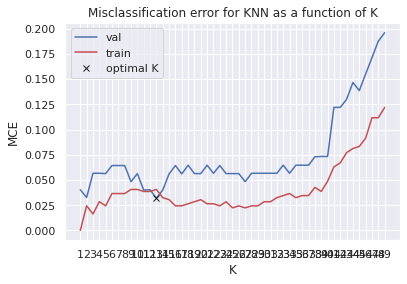

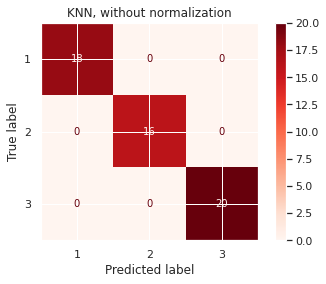

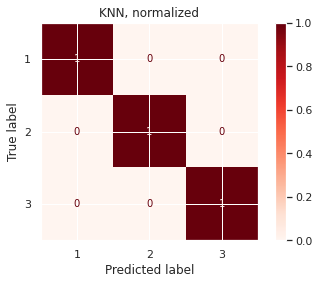

In [ ]:
K  = [i for i in range(1,50)]
MCE = []
MCE_train = []
for k in K:
  knn = KNeighborsClassifier(n_neighbors=k)

  MCE_CV = []
  MCE_CV_train = []
  for (train_idx,test_idx) in cv.split(X_train_new,y_train_new): # 5 iterations
    knn.fit(X_train_new[train_idx],y_train_new[train_idx])

    preds = knn.predict(X_train_new[test_idx])
    conf_matrix = confusion_matrix(y_train_new[test_idx],preds)
    dims = conf_matrix.shape
    off_diag = [conf_matrix[r,c] for r in range(dims[0]) for c in range(dims[1]) if r != c]
    MCE_CV.append(sum(off_diag)/len(y_train_new[test_idx]))

    preds_train = knn.predict(X_train_new[train_idx])
    conf_matrix_train = confusion_matrix(y_train_new[train_idx],preds_train)
    dims_train = conf_matrix_train.shape
    off_diag_train = [conf_matrix_train[r,c] for r in range(dims_train[0]) for c in range(dims_train[1]) if r != c]
    MCE_CV_train.append(sum(off_diag_train)/len(y_train_new[train_idx]))
    
  MCE.append(np.mean(MCE_CV))
  MCE_train.append(np.mean(MCE_CV_train))
best_idx = np.argmin(MCE)
best_k = K[best_idx]

plt.figure()
plt.plot(K,MCE,'b',label='val')
plt.plot(K,MCE_train,'r',label = 'train')
plt.xticks(K)
plt.plot(K[best_idx],MCE[best_idx],'kx',label = 'optimal K')
plt.title('Misclassification error for KNN as a function of K')
plt.xlabel('K')
plt.ylabel('MCE')
plt.legend()

# refit classifier with the optimal K, using the whole training set
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_new,y_train_new)

# Visualize the confusion matrix
titles_options = [('KNN, without normalization',None),
                  ('KNN, normalized','true')]

for title,normalize in titles_options:
  conf_matrix_KNN_disp = plot_confusion_matrix(knn,X_test_new,y_test_new,display_labels=set(y_train_new),
                                 cmap='Reds',
                                 normalize=normalize)
  conf_matrix_KNN_disp.ax_.set_title(title)

preds = knn.predict(X_test_new)
conf_matrix = confusion_matrix(y_test_new,preds)
dims = conf_matrix.shape
off_diag = [conf_matrix[r,c] for r in range(dims[0]) for c in range(dims[1]) if r != c]
MCE_KNN = sum(off_diag)/len(y_test)

MCEs = dict() # dictionary to store all the misclassification errors of the different classifiers


MCEs['KNN'] = MCE_KNN

# **One-vs-all classifier**


The second model we will use is of the binary classifier family. We will use two variations of this model, namely: Support Vector Machines (SVM) and Logistic Regression.
Because these model does not natively support the multiclass classification problem we have at hand in this project, we will employ meta-strategy algorithms to overcome this. Two examples of this heuristic method are one-vs-all classifier, and one-vs-one. We will be employing the one-vs-all- binary classifier. In essence this is an approach that involves splitting the multi-class dataset into multiple binary classification problems. The two binary classifiers we have chosen are then trained on each binary classification problem and predictions are made using the model that is the most confident.

## 1) Support Vector Classifier
In the Support Vector Classifier, abbreviated as SVC, we want to make a classification boundary for a dataset that is not completede linearly separable. This is an extension to the well-known maximal marginal classifier in which the clusters are completely separable, where we allow for samples to occur on the wrong side of the classification boundary, i.e misclassifications, by introducing slack variables $\varepsilon$. 

We have the following optimization problem: 

$\max_{\bf{\beta,\varepsilon}}M$ subject to 

$\\\sum_{j = 1}^{p}\beta_j^2$ = 1,

$y_i\bf{\beta}^T \bf{x_i} \ge M(1 - \varepsilon_i) \quad \forall i = 1,\dots, n$

$\sum_{i = 1}^{n}\varepsilon_i \le C$, $\varepsilon_i \ge 0 \; \forall i$, 

where

$M$ is the width if the margin, i.e the classification boundary.

$\varepsilon_0, \dots, \varepsilon_n$ are the slack variables to allow for misclassifications.

$C$ is the slack budget, which is a tuning parameter related to regularization of the model. A greater $C$ allows for more misclassifications, making the model more flexible. In the below code cell we perform 5-fold cross-validation to tune this hyperparameter.

The goal of the optimization is then to find the optimal model parameters $\bf{\beta}$ and slack parameters $\bf{\varepsilon}$ that best fits the training data.

An observation $\bf{x^*}$ is classified according to the following relation

$y^{*} = \begin{cases}
          -1 \; \text{for} \; f(\bf{x^*}) < 0 \\
           1 \; \text{for}  \; f(\bf{x^*}) > 0
          \end{cases}$, 

where $f(\bf{x}) = \beta_0 + \beta_1 x_1 + \dots + \beta_p x_p$



Misclassification error: 0.0


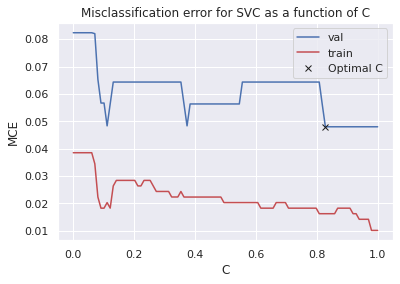

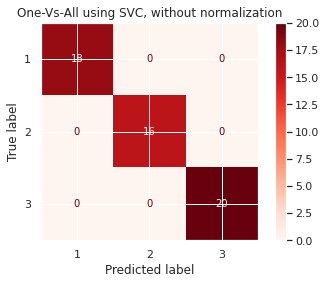

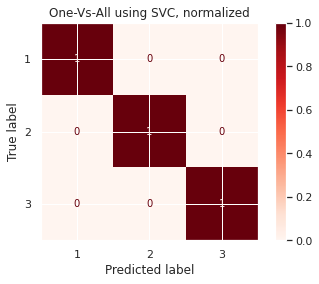

In [ ]:

# 5-fold CV for finding optimal cost of regularization
C = np.linspace(0.001,1,num= 100) # strictly positive

MCE = []
MCE_train = []
for c in C:
  binary_SVC = SVC(C = c,random_state = 42)
  MCE_CV = []
  MCE_CV_train = []

  for train_idx,test_idx in cv.split(X_train_new,y_train_new):
    multi_SVC = OneVsRestClassifier(binary_SVC).fit(X_train_new[train_idx],y_train_new[train_idx])
    preds = multi_SVC.predict(X_train_new[test_idx])
    conf_matrix = confusion_matrix(y_train_new[test_idx],preds)
    dims = conf_matrix.shape
    off_diag = [conf_matrix[r,c] for r in range(dims[0]) for c in range(dims[1]) if r!= c]
    MCE_CV.append(sum(off_diag)/len(y_train_new[test_idx]))

    preds_train = multi_SVC.predict(X_train_new[train_idx])
    conf_matrix_train = confusion_matrix(y_train_new[train_idx],preds_train)
    dims_train = conf_matrix_train.shape
    off_diag_train = [conf_matrix_train[r,c] for r in range(dims_train[0]) for c in range(dims_train[1]) if r!= c]
    MCE_CV_train.append(sum(off_diag_train)/len(y_train_new[train_idx]))
  MCE.append(np.mean(MCE_CV))
  MCE_train.append(np.mean(MCE_CV_train))
best_idx = np.argmin(MCE)
best_c = C[best_idx]

plt.figure()
plt.plot(C,MCE,'b',label = 'val')
plt.plot(C,MCE_train,'r',label = 'train')
plt.plot(best_c,MCE[best_idx],'kx',label = 'Optimal C')
plt.legend()
plt.title('Misclassification error for SVC as a function of C')
plt.xlabel('C')
plt.ylabel('MCE')

# refit classifier using optimal c on the full training set
binary_SVC = SVC(C = best_c)

multi_SVC = OneVsRestClassifier(binary_SVC).fit(X_train_new,y_train_new)

# Visualize the confusion matrix
titles_options = [('One-Vs-All using SVC, without normalization',None),
                  ('One-Vs-All using SVC, normalized','true')]

for title,normalize in titles_options:
  conf_matrix_SVC_disp = plot_confusion_matrix(multi_SVC,X_test_new,y_test_new,display_labels=set(y_train_new),
                                 cmap='Reds',
                                 normalize=normalize)
  conf_matrix_SVC_disp.ax_.set_title(title)

# calcualte MCE for once-vs-all svc classifier
preds = multi_SVC.predict(X_test_new)

conf_matrix_SVC = confusion_matrix(y_test_new,preds)
dims = conf_matrix_SVC.shape

off_diag = [conf_matrix_SVC[r,c] for r in range(dims[0]) for c in range(dims[1]) if r != c ]

MCE_SVC = sum(off_diag)/len(y_test_new)
print('Misclassification error: {}'.format(MCE_SVC))

MCEs['SVC'] = MCE_SVC


## 2) Logistic Regression

*Logistic* regression is said to be the go-to method for simple binary classification problems. The core of the method is the logistic function. It is an S-shaped curve that squishes its argument in the range [0,1]. This model works by first fitting a logistic regression model to our data set. The coefficients $ \hat{\beta_{0}} $ and $\hat{\beta_{1}}$ is estimated from the training data using maximum-likelihood estimation (MLE).

In logistic regression we assume that the target variable $Y$ is coded as $\{0,1\}$, with $Y_i$ being distributed as a bernoulli distribution with $p_i$ being the probability of success, i.e 
$$
Y_i = \begin{cases}
      1 \; \text{with probability} \; p_i \\
      0 \; \text{with probability} \; (1-p_i)
    \end{cases}
$$
We then $\textbf{link}$ the covariates $x$ with the probability $p_i$ using the logistic function

From the MLE we get estimates of the parameters $\beta$, i.e $\hat{\beta}$. Then, given a single covariate, or predictor, $x_0$, we can use the logistic regression model to make predictions of the probability of belonging to class 1 using the logistic function:

$\hat{p}(x_{0})={\frac{\hat{\beta_{0}}+\hat{\beta_{1x_{0}}}}{1+e^{\hat{\beta_{0}}+\hat{\beta_{1x_{0}}}}} }  $

Where the $\hat{p}(x_{0})$ is the estimated probability that the new observation belongs to class 1.

In the figure below we see an example of the logistic function fitted on data based on deafults on loans.
![picture](https://drive.google.com/uc?export=view&id=1f-5IK4MFFQ8xpWirYzWO283FFEaCMr-k)
Illustration of S-shaped logistic regression graph

Photo via https://www.math.ntnu.no/emner/TMA4268/2019v/4Classif/4Classif.html#logistic_regression

The only hyperparameter we are tuning for this model is the cost of regularization, where a greater value leads to a more rigid, or simple model.

Misclassification error: 0.0


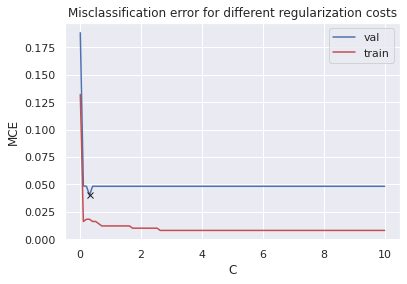

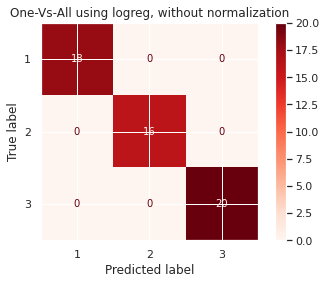

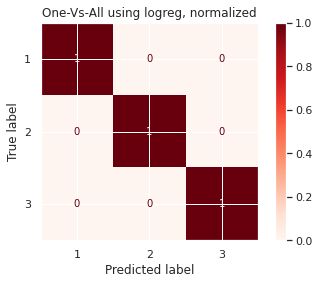

In [ ]:


# Parameter tuning - regularization cost of logistic regression 
C = np.linspace(0.01,10, num = 100) # strictly positive

MCE = []
MCE_train = []
for c in C:
  binary_logreg = LogisticRegression(C = c, random_state = 1)
  MCE_CV = []
  MCE_CV_train = []
  for train_idx,test_idx in cv.split(X_train_new,y_train_new):
    multi_logreg = OneVsRestClassifier(binary_logreg).fit(X_train_new[train_idx],y_train_new[train_idx])
    preds = multi_logreg.predict(X_train_new[test_idx])
    conf_matrix = confusion_matrix(y_train_new[test_idx],preds)
    dims = conf_matrix.shape
    off_diag = [conf_matrix[r,c] for r in range(dims[0]) for c in range(dims[1]) if r!=c]
    MCE_CV.append(sum(off_diag)/len(y_train_new[test_idx]))

    preds_train = multi_logreg.predict(X_train_new[train_idx])
    conf_matrix_train = confusion_matrix(y_train_new[train_idx],preds_train)
    dims_train = conf_matrix_train.shape
    off_diag_train = [conf_matrix_train[r,c] for r in range(dims_train[0]) for c in range(dims_train[1]) if r!=c]
    MCE_CV_train.append(sum(off_diag_train)/len(y_train_new[train_idx]))

  MCE.append(np.mean(MCE_CV))
  MCE_train.append(np.mean(MCE_CV_train))

best_idx = np.argmin(MCE)
C_best = C[best_idx]

plt.figure()
plt.plot(C,MCE,'b',label='val')
plt.plot(C,MCE_train,'r',label = 'train')
plt.plot(C_best,MCE[best_idx],'kx')
plt.title('Misclassification error for different regularization costs')
plt.xlabel('C')
plt.ylabel('MCE')
plt.legend()
# refit the best classifier on the full training set and plot confusion matrix
binary_logreg = LogisticRegression(C = C_best, random_state = 1)
multi_logreg = OneVsRestClassifier(binary_logreg).fit(X_train_new,y_train_new)


titles_options = [('One-Vs-All using logreg, without normalization',None),
                  ('One-Vs-All using logreg, normalized','true')]

for title,normalize in titles_options:
  conf_matrix_logreg_disp = plot_confusion_matrix(multi_logreg,X_test_new,y_test_new,display_labels=set(y_train_new),
                                 cmap='Reds',
                                 normalize=normalize)
  conf_matrix_logreg_disp.ax_.set_title(title)


# Compute MCE for one-vs-all logreg classifier, using the test set
preds = multi_logreg.predict(X_test_new)

conf_matrix_logreg = confusion_matrix(y_test_new,preds)

dims = conf_matrix_logreg.shape

off_diag = [conf_matrix_logreg[r,c] for r in range(dims[0]) for c in range(dims[1]) if r != c]

MCE_logreg = sum(off_diag)/len(y_test_new)

print('Misclassification error: {}'.format(MCE_logreg))

MCEs['logreg'] = MCE_logreg

# **Random Forest Classifier**

Random forest, consists of an ensemble of individual decision trees that operate together. Each tree in the forest produces a class prediction and the class with the most points becomes the model's final prediction, i.e the final prediction is a majority vote on the predictions done by the decision trees in the forest. The individual scores of the trees have a low correlation, which is key, thus the group will outperform any erronous individual prediction.

The random forest classifier is also widely used in the exploratory phase of a supervised machine learning project, as one can extract the importance of each explanatory variable in the regression.

![picture](https://drive.google.com/uc?export=view&id=1EJOE8hn0a0RrpBdBjBfwUppfI9IV7ux8)

 Image taken from:
 https://en.wikipedia.org/wiki/Decision_tree_learning
 
 For this model we are tuning two hyperparameters, namely the number of trees in the forest and the maximum depth of the decision trees in the forest. We are performing the 5-fold cross-validation once for each parameter we are tuning.
 When we find the best values of these parameters we refit the classifier using the full training set as described above.



Text(0.5, 0, 'n')

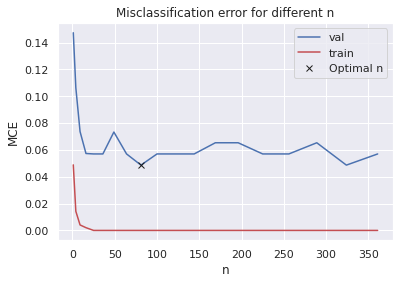

In [ ]:
rfc = RandomForestClassifier(random_state=1)
n_estimators = [i**2 for i in range(1,20)]

MCE = []
MCE_train = []

# consider a 5-fold CV
for n in n_estimators:
  rfc = RandomForestClassifier(random_state = 1, n_estimators = n)
  MCE_CV = []
  MCE_CV_train = []

  for train_idx,test_idx in cv.split(X_train_new,y_train_new):
    rfc.fit(X_train_new[train_idx],y_train_new[train_idx])
    # validation MCE
    preds = rfc.predict(X_train_new[test_idx])
    conf_matrix = confusion_matrix(y_train_new[test_idx],preds)
    dims = conf_matrix.shape
    off_diag = [conf_matrix[r,c] for r in range(dims[0]) for c in range(dims[1]) if r!= c]
    MCE_CV.append(sum(off_diag)/len(y_train_new[test_idx]))

    # training MCE
    preds_train = rfc.predict(X_train_new[train_idx])
    conf_matrix_train = confusion_matrix(y_train_new[train_idx],preds_train)
    dims_train = conf_matrix_train.shape
    off_diag_train = [conf_matrix_train[r,c] for r in range(dims_train[0]) for c in range(dims_train[1]) if r != c]
    MCE_CV_train.append(sum(off_diag_train)/len(y_train_new[train_idx]))

  MCE.append(np.mean(MCE_CV))
  MCE_train.append(np.mean(MCE_CV_train))

best_idx = np.argmin(MCE)
best_n = n_estimators[best_idx]

best_n
plt.figure()
plt.plot(n_estimators,MCE,'b',label = 'val')
plt.plot(n_estimators,MCE_train,'r',label = 'train')
plt.plot(n_estimators[best_idx],MCE[best_idx],'kx',label='Optimal n')
plt.legend()
plt.title('Misclassification error for different n')
plt.ylabel('MCE')
plt.xlabel('n')


Text(0.5, 0, 'D')

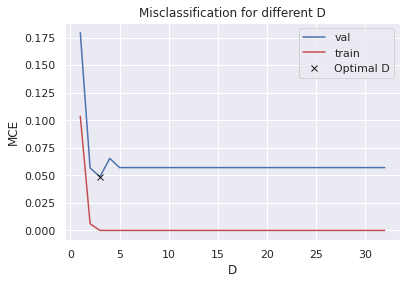

In [ ]:
max_depths = [i for i in range(1,33)]
max_depths.append(None)

MCE = []
MCE_train = []
for d in max_depths:
  rfc = RandomForestClassifier(random_state = 1,max_depth = d)
  MCE_CV = []
  MCE_CV_train = []
  for train_idx,test_idx in cv.split(X_train_new,y_train_new):
    rfc.fit(X_train_new[train_idx],y_train_new[train_idx])

    # Validation error
    preds = rfc.predict(X_train_new[test_idx])
    conf_matrix = confusion_matrix(y_train_new[test_idx],preds)
    dims = conf_matrix.shape
    off_diag = [conf_matrix[r,c] for r in range(dims[0]) for c in range(dims[1]) if r!= c]
    MCE_CV.append(sum(off_diag)/len(y_train[test_idx]))

    # Training error
    preds_train = rfc.predict(X_train_new[train_idx])
    conf_matrix_train = confusion_matrix(y_train_new[train_idx],preds_train)
    dims_train = conf_matrix_train.shape
    off_diag_train = [conf_matrix_train[r,c] for r in range(dims_train[0]) for c in range(dims[1]) if r!= c]
    MCE_CV_train.append(sum(off_diag_train)/len(y_train_new[train_idx]))
  MCE.append(np.mean(MCE_CV))
  MCE_train.append(np.mean(MCE_CV_train))

max_depth = max_depths[np.argmin(MCE)]

plt.figure() 
plt.plot(max_depths, MCE,'b',label = 'val')
plt.plot(max_depths,MCE_train,'r',label = 'train')
plt.plot(max_depth,np.min(MCE),'kx',label = 'Optimal D')
plt.legend()
plt.title('Misclassification for different D')
plt.ylabel('MCE')
plt.xlabel('D')



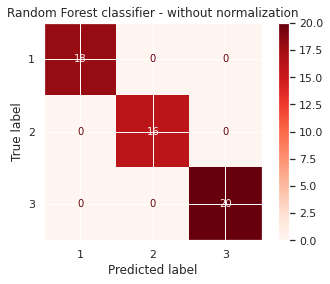

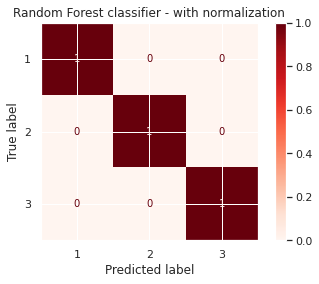

In [ ]:
# refit classifier on complete training set using optimal n and D found above
rfc = RandomForestClassifier(random_state=1,n_estimators=best_n, max_depth=max_depth)

rfc.fit(X_train_new,y_train_new)

# Visualize the confusion matrix
titles_options = [('Random Forest classifier - without normalization',None),
                  ('Random Forest classifier - with normalization','true')]


for title,normalize in titles_options:
  conf_matrix_RF_disp = plot_confusion_matrix(rfc,X_test_new,y_test_new,display_labels=set(y_train_new),
                                 cmap='Reds',
                                 normalize=normalize)
  conf_matrix_RF_disp.ax_.set_title(title)



In [ ]:
  # calculate MCE for the random forest classifier

preds = rfc.predict(X_test_new)
conf_matrix_RF = confusion_matrix(y_test_new,preds)

dims = conf_matrix_RF.shape


off_diag = [conf_matrix_RF[r,c] for r in range(dims[0]) for c in range(dims[1]) if r!= c]
MCE_RF = sum(off_diag)/len(y_test_new)

print('Misclassification error: {}'.format(MCE_RF))

MCEs['RF'] = MCE_RF


Misclassification error: 0.0


In [ ]:
MCE_df = pd.Series(MCEs)
MCE_df


KNN       0.0
SVC       0.0
logreg    0.0
RF        0.0
dtype: float64

We see that all the classifiers we consider is perfectly capable of classifying the correct class of wine in the test set, yielding zero misclassification error. This is also apparent from the above confusion matrices, where all elements lies on the diagonal where the predicted class is the actual class of the sample in the test set

# **Conclusion**

In this project we have considered a handful of classical machine learning techniques for a multi-class classification problem about wine types. We used K Nearest Neighbours (KNN), two types of One-vs-all classifiers based on Support Vector Classifier (SVC) and Logistic Regression, and Random Forest (RF) classifier. The goal of this project was to compare the predictive results of these classifiers in terms of the misclassification rate on the test test. 

The dataset we use is rather sparse, with a full dataset containing 177 samples. Using a $30 \%$ train-test split we ended up with 123 samples in the training dataset, which is also used for validation and parameter tuning, and 54 samples in the test set. To tackle this and to avoid overfitting we used the variable importance inherent in the random forest classifier to pick the most important variables in terms of predictive power. 

We see that all the classifiers we consider yields zero misclassification rates, meaning that they are perfectly capable of predicting the correct classes in the test set. This is most likely due to low variability in our dataset, meaning that the samples in the test set is very much alike those in the training set. 

As for future work and extensions, it would be interesting to test to algorithms on a dataset with greater variabililty, yielding different misclassification rates for the different classifiers.


